In [16]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass

import warnings

warnings.warn = warn

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os.path


from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix,precision_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline, make_pipeline

In [18]:
if(os.path.exists("../../data/train_test_validate_data/train_test_data.csv")):
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")
else:
    ownership_df_class = pd.read_csv("../../data/final_data/final_ownership_data.csv")
    sales_df_reg = pd.read_csv("../../data/final_data/final_sales_data.csv")
    
    ownership_df_class = ownership_df_class.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg.drop(columns=['Unnamed: 0', '_c0'])
    sales_df_reg = sales_df_reg[['Annual_Income', 'Price']]

    def find_closest_income_match(target_income, reference_df):
        closest_income_idx = (reference_df['Annual_Income'] - target_income).abs().idxmin()
        return reference_df.loc[closest_income_idx, 'Price']

    ownership_df_class['Price'] = ownership_df_class.apply(
        lambda row: find_closest_income_match(row['Annual_Income'], sales_df_reg)
        if row['Car'] == 'Yes'
        else 0,
        axis=1
        )

    ownership_sales = ownership_df_class.__deepcopy__()
    ownership_sales.to_csv(path_or_buf="../../data/train_test_validate_data/train_test_data.csv")
    data = pd.read_csv("../../data/train_test_validate_data/train_test_data.csv")

In [19]:
data

,Unnamed: 0,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children,Price
0,0,Teacher,52800.0,750,10,Good,Yes,2,57000
1,1,Engineer,79200.0,800,8,Good,Yes,1,15000
2,2,Nurse,33000.0,650,5,Fair,No,0,0
3,3,Doctor,105600.0,900,12,Excellent,Yes,3,26001
4,4,Businessman,132000.0,700,15,Good,Yes,2,26001
...,...,...,...,...,...,...,...,...,...
391,391,Customer Support,4620.0,640,3,Stable,No,1,0
392,392,Dental Hygienist,6336.0,670,4,Stable,Yes,2,19000
393,393,Project Manager,9240.0,730,5,Stable,Yes,0,39000
394,394,Medical Assistant,4620.0,640,3,Stable,No,1,0


In [20]:
data_class = data.__deepcopy__()
data_reg = data.__deepcopy__()

In [21]:
data_class = data_class.drop(columns=['Price', 'Unnamed: 0'])
data_class

,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
0,Teacher,52800.0,750,10,Good,Yes,2
1,Engineer,79200.0,800,8,Good,Yes,1
2,Nurse,33000.0,650,5,Fair,No,0
3,Doctor,105600.0,900,12,Excellent,Yes,3
4,Businessman,132000.0,700,15,Good,Yes,2
...,...,...,...,...,...,...,...
391,Customer Support,4620.0,640,3,Stable,No,1
392,Dental Hygienist,6336.0,670,4,Stable,Yes,2
393,Project Manager,9240.0,730,5,Stable,Yes,0
394,Medical Assistant,4620.0,640,3,Stable,No,1


In [22]:
data_reg = data_reg.where(cond=(data_reg['Car'] == 'Yes')).dropna(axis=0).drop(columns=['Unnamed: 0', 'Car', 'Occupation'])
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price
0,52800.0,750.0,10.0,Good,2.0,57000.0
1,79200.0,800.0,8.0,Good,1.0,15000.0
3,105600.0,900.0,12.0,Excellent,3.0,26001.0
4,132000.0,700.0,15.0,Good,2.0,26001.0
6,46200.0,700.0,8.0,Fair,-1.0,15001.0
...,...,...,...,...,...,...
388,5940.0,670.0,4.0,Stable,2.0,17000.0
389,6336.0,660.0,3.0,Stable,1.0,19000.0
390,11220.0,750.0,7.0,Stable,0.0,13000.0
392,6336.0,670.0,4.0,Stable,2.0,19000.0


In [23]:
data_reg['Finance_Status'].unique()

array(['Good', 'Excellent', 'Fair', 'Stable', 'Unstable', 'Unknown'],
      dtype=object)

In [24]:
label_mapping = {
    'Unknown': 0,      
    'Unstable': 1,     
    'Fair': 2,         
    'Stable': 3,       
    'Good': 4,         
    'Excellent': 5     
}


In [25]:
data_reg['Finance_Status'] = data_reg['Finance_Status'].replace(label_mapping)
data_reg

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children,Price
0,52800.0,750.0,10.0,4,2.0,57000.0
1,79200.0,800.0,8.0,4,1.0,15000.0
3,105600.0,900.0,12.0,5,3.0,26001.0
4,132000.0,700.0,15.0,4,2.0,26001.0
6,46200.0,700.0,8.0,2,-1.0,15001.0
...,...,...,...,...,...,...
388,5940.0,670.0,4.0,3,2.0,17000.0
389,6336.0,660.0,3.0,3,1.0,19000.0
390,11220.0,750.0,7.0,3,0.0,13000.0
392,6336.0,670.0,4.0,3,2.0,19000.0


In [26]:
Y = data_reg['Price']
X = data_reg.drop(columns=['Price'])
X

,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Number_of_Children
0,52800.0,750.0,10.0,4,2.0
1,79200.0,800.0,8.0,4,1.0
3,105600.0,900.0,12.0,5,3.0
4,132000.0,700.0,15.0,4,2.0
6,46200.0,700.0,8.0,2,-1.0
...,...,...,...,...,...
388,5940.0,670.0,4.0,3,2.0
389,6336.0,660.0,3.0,3,1.0
390,11220.0,750.0,7.0,3,0.0
392,6336.0,670.0,4.0,3,2.0


In [27]:
Y

0      57000.0
1      15000.0
3      26001.0
4      26001.0
6      15001.0
        ...   
388    17000.0
389    19000.0
390    13000.0
392    19000.0
393    39000.0
Name: Price, Length: 250, dtype: float64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=42)

In [29]:
reg_model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
reg_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

In [30]:
reg_model.fit(x_train, y_train)
y_pred = reg_model.predict(x_test)

In [31]:
# 1. Basic Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.2f}')
print(f'Explained Variance: {ev:.2f}')

cv_scores = cross_val_score(reg_model, X, Y, cv=5, scoring='r2')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean():.2f} ± {cv_scores.std()*2:.2f}')

MSE: 24424539408373.77
RMSE: 4942118.92
MAE: 747758.11
R²: -172558.16
Explained Variance: -171596.75
Cross-validation scores: [-4.39906795e+12 -2.42020945e+05 -1.40726695e+04 -8.41183285e-01
 -8.62803990e+00]
Average CV score: -879813641915.10 ± 3519254311557.32


In [32]:
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'
}

# Create pipelines for each model
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

ridge_params = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 300.0, 400.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

lasso_params = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 300.0, 400.0],
    'model__selection': ['cyclic', 'random'],
    'model__max_iter': [1000, 2000]  
}

elastic_params = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 150.0, 200.0, 300.0, 400.0],
    'model__l1_ratio': [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0],
    'model__selection': ['cyclic', 'random'],
    'model__max_iter': [1000, 2000]  
}


def perform_grid_search(pipeline, params, model_name, X, y):
    grid_search = GridSearchCV(
        pipeline,
        params,
        cv=5,
        scoring=scoring,
        refit='r2',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_r2 = grid_search.best_score_

    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_index = grid_search.best_index_

    results = {
        'model_name': model_name,
        'best_params': best_params,
        'best_r2': best_r2,
        'best_mse': -cv_results.loc[best_index, 'mean_test_neg_mse'],
        'best_rmse': np.sqrt(-cv_results.loc[best_index, 'mean_test_neg_mse']),
        'best_mae': -cv_results.loc[best_index, 'mean_test_neg_mae']
    }

    return grid_search, results

models = [
    (ridge_pipeline, ridge_params, 'Ridge'),
    (lasso_pipeline, lasso_params, 'Lasso'),
    (elastic_pipeline, elastic_params, 'ElasticNet')
]

results_list = []
best_models = {}

for pipeline, params, name in models:
    grid_search, results = perform_grid_search(pipeline, params, name, x_train, y_train)
    results_list.append(results)
    best_models[name] = grid_search

results_df = pd.DataFrame(results_list)
print("\nModel Comparison:")
print(results_df)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Fitting 5 folds for each of 448 candidates, totalling 2240 fits

Model Comparison:
   model_name                                        best_params   best_r2  \
0       Ridge   {'model__alpha': 200.0, 'model__solver': 'lsqr'}  0.006947   
1       Lasso  {'model__alpha': 400.0, 'model__max_iter': 100... -0.009334   
2  ElasticNet  {'model__alpha': 1.0, 'model__l1_ratio': 0.0, ...  0.006687   

       best_mse     best_rmse      best_mae  
0  1.503501e+08  12261.733346  10398.235839  
1  1.509671e+08  12286.867466  10566.966177  
2  1.502015e+08  12255.670155  10433.602079  


In [33]:
best_model_idx = results_df['best_r2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model_name']
best_model = best_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print("Best Parameters:", results_df.loc[best_model_idx, 'best_params'])
print(f"R² Score: {results_df.loc[best_model_idx, 'best_r2']:.4f}")
print(f"RMSE: {results_df.loc[best_model_idx, 'best_rmse']:.4f}")
print(f"MAE: {results_df.loc[best_model_idx, 'best_mae']:.4f}")


Best Model: Ridge
Best Parameters: {'model__alpha': 200.0, 'model__solver': 'lsqr'}
R² Score: 0.0069
RMSE: 12261.7333
MAE: 10398.2358


In [34]:
y_pred = best_model.predict(x_test)

test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print("\nTest Set Results for Best Model:")
print(f"Model: {best_model_name}")
print(f"Parameters: {best_model.best_params_}")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")


Test Set Results for Best Model:
Model: Ridge
Parameters: {'model__alpha': 200.0, 'model__solver': 'lsqr'}
R² Score: -0.0279
RMSE: 12061.8569
MAE: 8912.6644


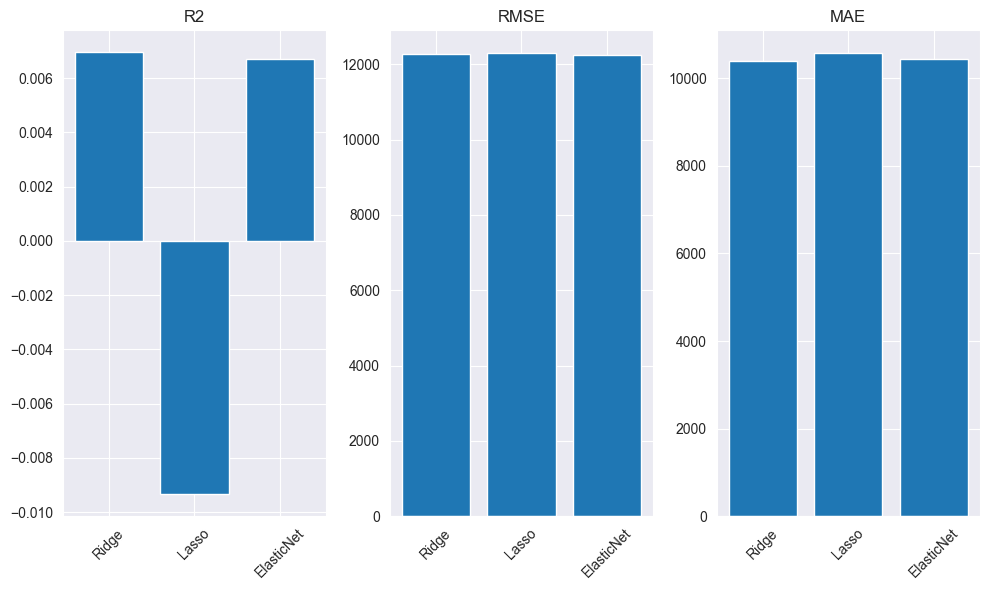

In [35]:
plt.figure(figsize=(10, 6))
metrics = ['best_r2', 'best_rmse', 'best_mae']
for metric in metrics:
    plt.subplot(1, 3, metrics.index(metric) + 1)
    plt.bar(results_df['model_name'], results_df[metric])
    plt.title(metric.replace('best_', '').upper())
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()